In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import os
import pickle

In [3]:
# data = pd.read_csv('../data/cells/test.csv')
# data.head()

In [3]:
controls = pd.concat([
    pd.read_csv('../data/cells/train_controls.csv'),
    pd.read_csv('../data/cells/test_controls.csv'),
])
controls.head()

,id_code,experiment,plate,well,sirna,well_type
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1138,negative_control
1,HEPG2-01_1_C03,HEPG2-01,1,C03,1109,positive_control
2,HEPG2-01_1_C07,HEPG2-01,1,C07,1121,positive_control
3,HEPG2-01_1_C11,HEPG2-01,1,C11,1126,positive_control
4,HEPG2-01_1_C15,HEPG2-01,1,C15,1118,positive_control


In [4]:
len(controls.groupby(['experiment', 'plate']))

204

In [5]:
controls = controls.iloc[(controls['well_type'] == 'negative_control').values]
len(controls.groupby(['experiment', 'plate']))

204

In [6]:
controls['sirna'].unique()

array([1138])

In [7]:
controls.groupby(['experiment', 'plate'])

In [8]:
s = None
u = controls.groupby(['experiment', 'plate'])['sirna'].unique()

for row in u:
    if s is None:
        s = set(row)
        
    s = s.intersection(row)

# Plate patterns

In [143]:
train = pd.read_csv('../data/cells/train.csv')

# tmp = train.groupby('sirna').plate.unique()
# tmp = tmp.apply(lambda xs: {1, 2, 3, 4}.difference(xs))
# tmp = tmp.apply(lambda xs: list(xs)[0])
# np.save('./ignored.npy', tmp.values)

tmp = train.groupby('sirna').plate.unique()
np.save('./ignored.npy', np.array(list(tmp.values)))

# Plate Stats

In [9]:
# data = pd.read_csv('../data/cells/train_controls.csv')
# print(data.columns)
# data = data[(data['sirna'] == 1138) & (data['well_type'] == 'negative_control')]
# len(data)

In [10]:
# df = pd.merge(data, stats, on=['experiment', 'plate', 'well'], how='inner')
# print(df.columns)
# len(df)

In [11]:
stats = pd.read_csv('../data/cells/pixel_stats.csv')
stats = stats[stats['well'] == 'B02']

In [12]:
res = {}
for (exp, plate, well), group in stats.groupby(['experiment', 'plate', 'well']):
    assert well == 'B02'

    plate_stats = []
    for site, group in group.groupby('site'):
        assert all(group['channel'] == range(1, 7))
        plate_stats.append(group[['mean', 'std']].values)

    k = '{}_{}'.format(exp, plate)
    res[k] = torch.tensor(plate_stats).float() / 255
    assert res[k].size() == (2, 6, 2)
    
assert len(res) == 204

torch.save(res, './plate_stats.pth')

# Transforms

In [13]:
import  torchvision.transforms as T

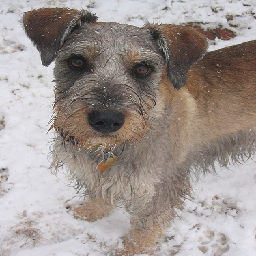

In [14]:
image = Image.open('../imet/sample.jpg')
image = image.resize((256, 256))
image

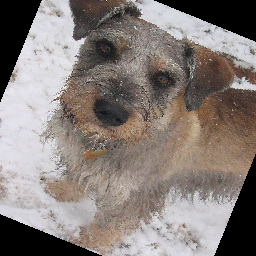

In [15]:
t = T.RandomRotation(360)
t(image)

# Fold Splits

In [71]:
import sys
print(np.__version__)
sys.path.append('../../rxrx1-utils')
import rxrx.io as rio

1.16.3


ModuleNotFoundError: No module named 'rxrx'

In [70]:
def show_controls(controls):
    for exp, group in controls.groupby('experiment'):
#         if exp[-2:] in ['12', '13', '16', '05', '09', '10', '14', '03', '06', '08', '07', '11', '15']:
#             continue 
            
        print(exp)
        plt.figure(figsize=(14, 3))

        for plate, group in group.groupby('plate'):
            for site in [1, 2]:
                row = group.iloc[0]
                assert row['well'] == 'B02'
                image = rio.load_site(row['subset'], exp, plate, row['well'], site, base_path=row['root'])
                image = rio.convert_tensor_to_rgb(image)
                
                plt.subplot(1, 8, (plate - 1) * 2 + site)
                plt.axis('off')
                plt.title(plate)
                plt.imshow(image)

        plt.tight_layout()
        plt.suptitle(exp)
        plt.show()

root = '../data/cells'

train_controls = pd.read_csv(os.path.join(root, 'train_controls.csv'))
train_controls['subset'] = 'train'

test_controls = pd.read_csv(os.path.join(root, 'test_controls.csv'))
test_controls['subset'] = 'test'

controls = pd.concat([
    train_controls,
#     test_controls,
])
controls['root'] = root
controls['cell_type'] = controls['experiment'].apply(lambda x: x.split('-')[0])
print(controls['cell_type'].unique())

controls = controls[controls['sirna'] == 1138]
controls = controls[controls['cell_type'] == 'U2OS']

show_controls(controls)

['HEPG2' 'HUVEC' 'RPE' 'U2OS']
U2OS-01


NameError: name 'rio' is not defined

<Figure size 1008x216 with 0 Axes>

In [51]:
import sklearn.cluster

kmeans = sklearn.cluster.KMeans(3)
experiment_stats = torch.load('../experiment_stats.pth')

exps = experiment_stats.keys()
values = torch.stack([torch.cat(experiment_stats[exp], 0) for exp in exps], 0)
values = values.numpy()

kmeans.fit(values)
ids = kmeans.predict(values)
ids

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0], dtype=int32)

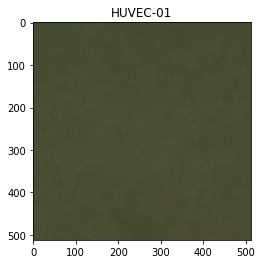

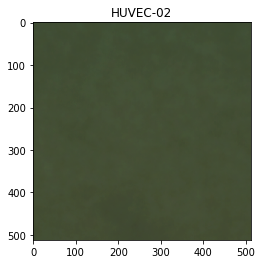

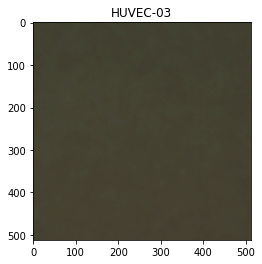

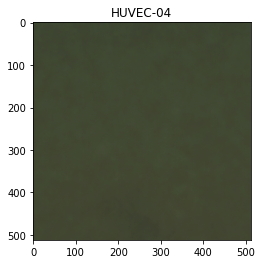

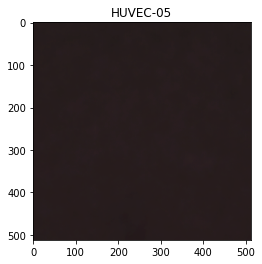

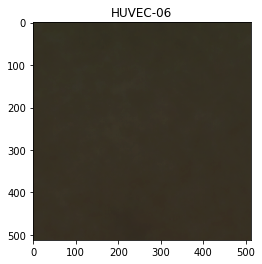

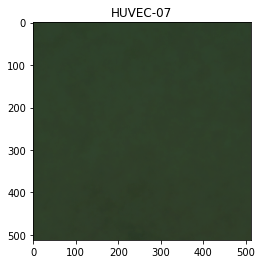

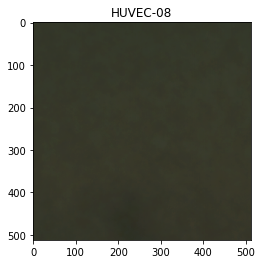

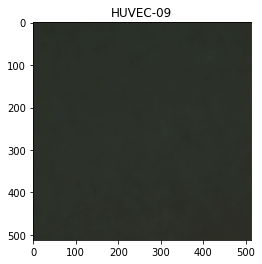

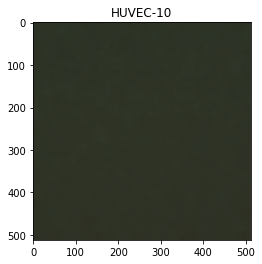

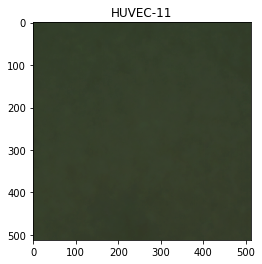

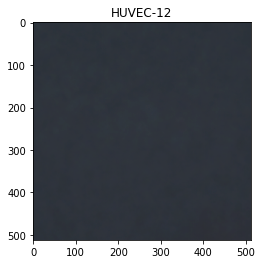

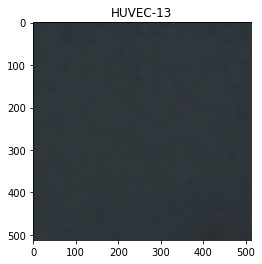

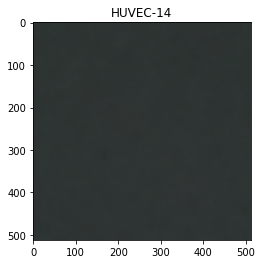

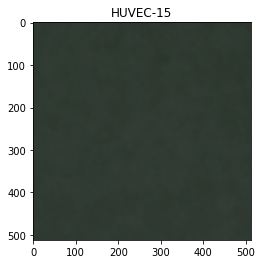

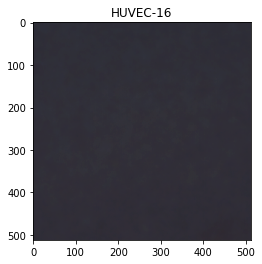

In [58]:
with open('../mean_images.pkl', 'rb') as f:
    mean_images = pickle.load(f)

for exp, image in mean_images.items():
    if not exp.startswith('HUVEC'):
        continue 
        
    image = rio.convert_tensor_to_rgb(image)
    plt.figure(figsize=(4, 4))
    plt.title(exp)
    plt.imshow(image)
    plt.show()

In [68]:
import torch
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import os
import lap
from sklearn.model_selection import StratifiedKFold

N_FOLDS = 3

train = pd.read_csv('../data/cells/train.csv')
train_exps = set(train['experiment'].unique())

stats = torch.load('../experiment_stats.pth')
exps = np.array([e for e in stats.keys() if e in train_exps])
types = np.array([e.split('-')[0] for e in exps])
stats = np.array([torch.stack(list(stats[e])).data.cpu().numpy() for e in exps])
stats = stats.reshape((stats.shape[0], stats.shape[1] * stats.shape[2]))

for t in ['HEPG2', 'HUVEC', 'RPE', 'U2OS']:
    print(t, '>' * 10)
#     e = exps[types == t]
#     x = stats[types == t]
    e = exps
    x = stats

    m = x.mean(0, keepdims=True)
    s = x.std(0, keepdims=True)
    assert m.shape == s.shape == (1, 12)
    x = (x - m) / s
    
    n  = np.floor(e.shape[0] / min(e.shape[0], N_FOLDS)).astype(np.int32)
    kmeans = KMeans(n, n_init=1000, max_iter=1000, random_state=42, n_jobs=os.cpu_count())
    
    d = kmeans.fit_transform(x)
    cs = np.arange(n)
    print(d.shape)
    
    reps = np.ceil(d.shape[0] / d.shape[1]).astype(np.int32)
    d = np.tile(d, (1, reps))
    cs = np.tile(cs, (reps,))
    print(d.shape)
    
    _, c, _ = lap.lapjv(d, extend_cost=True)
    c = cs[c]

    for a, b in zip(e, c):
        print(a, b)
    
    print(np.bincount(c))
    break
    
kfold = StratifiedKFold(N_FOLDS, shuffle=True, random_state=42)
for fold, (ti, vi) in enumerate(kfold.split(e, c)):
    print('FOLD', fold, '>' * 10)
    print(np.bincount(c[vi]))
    print(sorted(e[vi]))
#     for a, b in zip(e[vi], c[vi]):
#         print()

HEPG2 >>>>>>>>>>
(33, 11)
(33, 33)
HEPG2-01 1
HEPG2-02 9
HEPG2-03 5
HEPG2-04 4
HEPG2-05 6
HEPG2-06 9
HEPG2-07 7
HUVEC-01 10
HUVEC-02 10
HUVEC-03 2
HUVEC-04 10
HUVEC-05 6
HUVEC-06 7
HUVEC-07 9
HUVEC-08 2
HUVEC-09 7
HUVEC-10 3
HUVEC-11 2
HUVEC-12 5
HUVEC-13 5
HUVEC-14 3
HUVEC-15 3
HUVEC-16 6
RPE-01 0
RPE-02 0
RPE-03 0
RPE-04 8
RPE-05 8
RPE-06 8
RPE-07 1
U2OS-01 4
U2OS-02 1
U2OS-03 4
[3 3 3 3 3 3 3 3 3 3 3]
FOLD 0 >>>>>>>>>>
[1 1 1 1 1 1 1 1 1 1 1]
['HEPG2-04', 'HUVEC-01', 'HUVEC-03', 'HUVEC-05', 'HUVEC-07', 'HUVEC-09', 'HUVEC-12', 'HUVEC-14', 'RPE-01', 'RPE-04', 'RPE-07']
FOLD 1 >>>>>>>>>>
[1 1 1 1 1 1 1 1 1 1 1]
['HEPG2-03', 'HEPG2-05', 'HEPG2-06', 'HUVEC-04', 'HUVEC-06', 'HUVEC-08', 'HUVEC-15', 'RPE-02', 'RPE-05', 'U2OS-01', 'U2OS-02']
FOLD 2 >>>>>>>>>>
[1 1 1 1 1 1 1 1 1 1 1]
['HEPG2-01', 'HEPG2-02', 'HEPG2-07', 'HUVEC-02', 'HUVEC-10', 'HUVEC-11', 'HUVEC-13', 'HUVEC-16', 'RPE-03', 'RPE-06', 'U2OS-03']


In [69]:
# metric: 0.9043, temp: 0.016

import pandas as pd
a = pd.read_csv('../data/cells/train.csv')
b = pd.read_csv('../eval.csv')

a = a[['id_code', 'sirna']]
b = b[['id_code', 'sirna']]

assert len(a) == len(b)

c = a.merge(b, on='id_code',  suffixes=('_true', '_pred'))
c['exp'] = c['id_code'].apply(lambda x: x.split('_')[0])
c['eq'] = c['sirna_true'] == c['sirna_pred']
print(c['eq'].mean())

stats = c.groupby('exp')['eq'].mean().sort_values()
print(stats)

import torch
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import os
import matplotlib.pyplot as plt
import lap
from sklearn.model_selection import StratifiedKFold

N_FOLDS = 3

e = stats.index.values
x = stats.values.reshape((len(stats), 1))

m = x.mean(0, keepdims=True)
s = x.std(0, keepdims=True)
assert m.shape == s.shape == (1, 1)
x = (x - m) / s

n = np.floor(e.shape[0] / min(e.shape[0], N_FOLDS)).astype(np.int32)
kmeans = KMeans(n, n_init=1000, max_iter=1000, random_state=42, n_jobs=os.cpu_count())

d = kmeans.fit_transform(x)
cs = np.arange(n)
print(d.shape)

reps = np.ceil(d.shape[0] / d.shape[1]).astype(np.int32)
d = np.tile(d, (1, reps))
cs = np.tile(cs, (reps,))
print(d.shape)

_, c, _ = lap.lapjv(d, extend_cost=True)
c = cs[c]
print(np.bincount(c))
    
kfold = StratifiedKFold(N_FOLDS, shuffle=True, random_state=42)
for fold, (ti, vi) in enumerate(kfold.split(e, c)):
    print('FOLD', fold, '>' * 10)
    print(np.bincount(c[vi]))
    print(sorted(e[vi]))

0.9042859099000411
exp
HUVEC-05    0.087545
HEPG2-01    0.330922
HEPG2-02    0.618445
U2OS-02     0.681408
U2OS-01     0.814079
HEPG2-05    0.878159
HEPG2-04    0.933213
HEPG2-03    0.934116
RPE-07      0.950361
HEPG2-06    0.957581
U2OS-03     0.959386
HEPG2-07    0.963834
RPE-04      0.970190
RPE-06      0.971067
RPE-01      0.971119
RPE-03      0.972924
RPE-05      0.974729
HUVEC-09    0.981047
RPE-02      0.981047
HUVEC-15    0.981718
HUVEC-14    0.985321
HUVEC-16    0.986462
HUVEC-11    0.992780
HUVEC-02    0.994585
HUVEC-01    0.994585
HUVEC-06    0.995483
HUVEC-07    0.996387
HUVEC-03    0.996390
HUVEC-08    0.996390
HUVEC-04    0.996390
HUVEC-13    0.997278
HUVEC-12    0.998195
HUVEC-10    1.000000
Name: eq, dtype: float64
(33, 11)
(33, 33)
[3 3 3 3 3 3 3 3 3 3 3]
FOLD 0 >>>>>>>>>>
[1 1 1 1 1 1 1 1 1 1 1]
['HEPG2-03', 'HEPG2-05', 'HUVEC-07', 'HUVEC-09', 'HUVEC-13', 'HUVEC-16', 'RPE-02', 'RPE-05', 'RPE-06', 'U2OS-01', 'U2OS-02']
FOLD 1 >>>>>>>>>>
[1 1 1 1 1 1 1 1 1 1 1]
['HEPG2-